# Modelling Lead Conversion
#### PROBLEM DESCRIPTION

The file `CustomerData_LeadGenerator.csv` contains customers data and data of the area that the customers are living (or where a business is located) in. Additionally, there are data that indicate whether a customer has been contacted and whether this contacted customer buys a product in the end. From these data, we can build a data-driven model that learns the pattern of lead conversion into buying customers. The model will then help the company to focus the marketing target for better conversion rate as well as understand the behavior of the lead conversion better to personalize the marketing strategies.

## 0. Introduction
This Jupyter notebook is intended to provide the step-by-step approaches that I took in solving the task. I try to write all the assumptions for decisions and choices that I make.

In this task, I decided to use the <b>logistic regression</b> as a model, since the task is a classification problem. To find the best performing model, I performed a simple <b>hyperparameter search</b> by comparing models with different <b>regularization strengths</b>, as well as <b>feature selection</b> since some features are highly correlated. As a result, I managed to build a model with an <b>accuracy score of 60%</b>, <b>precision, recall, and F1-score of 67%</b>, which is slightly better compared to random guessing, considering the extremely low number of training data. A more detailed analysis, evaluation, conclusion, and outlook are presented in details in this notebook.

The outline of this notebook follows the steps that I take in solving this task:
- [1. Code and environment configuration](#1.-Code-and-environment-configuration): Importing libraries and list of the version used
- [2. Data loading and preprocessing](#2.-Data-loading-and-preprocessing): Loading, inspecting, preprocessing the data
- [3. Data exploration](#3.-Data-exploration): Inspection of the data distribution
- [4. Model building](#4.-Model-building): Feature selection, data split, and model implementation
- [5. Conclusions and recommendations](#5.-Conclusions-and-recommendations): Here I conclude the findings and discuss potential improvement for the model

## 1. Code and environment configuration
This code was written and run with Python 3.8.8, with the following libraries:
- numpy 1.23.4
- pandas 1.5.0
- scikit-klearn 1.0.1
- matplotlib 3.4.1
- seaborn 0.11.2

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Data loading and preprocessing

First, the csv file is read using pandas, then it is inspected by printing the info and description of the dataframe. The file is stored in the directory `data`, which is located in the same directory as the code. From all the available data, I am interested in understanding the lead conversion pattern after they have been contacted by the company, so that the company can focus its marketing effort to targets with higher potential of conversion. I assume that the column `b_in_kontakt_gewesen` identifies the potential leads that have been contacted by the company. Therefore, to train the model, I filtered the data using this column (where `b_in_kontakt_gewesen = 1`). One big problem arise, which is the number of available data. The filtering of the data result in a total of only 95 data entries, leaving us with a small amount of data to train. This issue is discussed later in the model building section.

There are 26 columns of data. Since no explanations are given for them, I assume each column's description based on their names. I also assume that the potential customers are a mix between private and business customers, since there are columns specifying the specializations, opening days and hours (also 0 opening days and hours that might indicate private customers), as well as also data about the region where they are located. My assumptions for the data are as follow:
- `fakeID`: Unique ID of a potential customer
- `b_specialisation_a` - `b_specialisation_j`: Specialisation of the potential customer (categorical variable)
- `q_OpeningDays`: The number of days in a week where the business is open
- `q_OpeningHours`: The total opening hours of the business (possibly in a week)
- `q_2017 Average Household Size`: Average number of people in a household in 2017 (Total population divided by the total households)
- `q_2017 Total Households`: Total households in the region in 2017
- `q_2017 HHs: 5th Quintile (68.759 and above)` : Total households possibly with income higher than 68.759
- `q_5th Quint by Total HH`: The 5th quintile of the household income normalized by the total households
- `q_2017 Purchasing Power: Per Capita`: Average purchasing power of a person in 2017
- `q_2017 Total Population`: Total population in 2017
- `q_2017 Pop 15+/Edu: University, Fachhochschule`: Total population who receives higher education
- `q_Uni by Total Pop`: Number of universities in the region divided by the total population
- `q_2017 Personal Care: Per Capita`: Average money spent on personal care per person in 2017
- `q_2017 Medical Products: Per Capita`: Average money spent on medical products per person in 2017
- `q_2017 Personal Effects: Per Capita`: Average money spent on personal effects per person in 2017
- `b_in_kontakt_gewesen`: Indicator whether a potential customer has been contacted (categorical variable)
- `b_gekauft_gesamt`: Indicator whether a lead is converted into a buying customer (categorical variable)

In [2]:
# Read the csv file and store the data in a pandas dataframe
df = pd.read_csv('data/CustomerData_LeadGenerator.csv')
df = df[df['b_in_kontakt_gewesen'] == 1].reset_index(drop=True)

# Inspect the dataframe
print('Data:')
df.head(10)

Data:


,fakeID,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,...,q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_2017 Total Population,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_Uni by Total Pop,q_2017 Personal Care: Per Capita,q_2017 Medical Products: Per Capita,q_2017 Personal Effects: Per Capita,b_in_kontakt_gewesen,b_gekauft_gesamt
0,1069_7334,0,0,0,0,0,0,0,0,0,...,0.186735,23730.35,2194057,324656,0.147971,593.19,326.28,235.75,1,1
1,328_2350,0,0,0,1,1,1,0,0,0,...,0.179848,23343.26,1966798,281130,0.142938,588.54,320.36,230.66,1,1
2,865_6285,0,0,0,1,0,1,0,0,0,...,0.184935,23674.18,2149624,320326,0.149015,592.88,325.57,234.82,1,1
3,47_307,0,1,1,0,0,0,0,0,0,...,0.184523,23572.26,2161445,310981,0.143876,590.84,324.06,233.81,1,0
4,342_2513,0,0,0,0,0,1,0,0,0,...,0.189871,23821.63,2302959,334940,0.145439,593.56,327.75,237.41,1,1
5,584_4117,0,1,1,0,1,0,0,0,0,...,0.186277,23729.24,2167697,324246,0.149581,593.43,327.08,235.73,1,1
6,995_7075,0,0,0,0,0,0,0,0,0,...,0.187219,23699.61,2234581,324379,0.145163,592.21,325.95,235.63,1,1
7,143_7711,0,0,0,0,0,0,0,0,0,...,0.248845,24058.93,307435,21676,0.070506,580.52,324.49,248.99,1,1
8,1055_7298,1,0,1,0,0,0,0,0,1,...,0.187963,23773.74,2225683,328527,0.147607,593.51,326.95,236.46,1,1
9,151_4934,0,1,1,0,0,0,0,1,1,...,0.161965,22865.72,247705,25735,0.103894,581.96,346.16,234.65,1,1


In [3]:
# Print the information of the dataframe, namely check missing values and data types of all columns
print('Dataframe information: ')
df.info()

Dataframe information: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 26 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   fakeID                                          95 non-null     object 
 1   b_specialisation_i                              95 non-null     int64  
 2   b_specialisation_h                              95 non-null     int64  
 3   b_specialisation_g                              95 non-null     int64  
 4   b_specialisation_f                              95 non-null     int64  
 5   b_specialisation_e                              95 non-null     int64  
 6   b_specialisation_d                              95 non-null     int64  
 7   b_specialisation_c                              95 non-null     int64  
 8   b_specialisation_b                              95 non-null     int64  
 9   b_specialisation_a   

In [4]:
# Print summary statistics of the dataframe
# This is printed in two halves, since there are 26 columns and therefore, some columns will not be shown if printed only once
print('Dataframe columns description first part: ')
df[df.columns[:11]].describe()

Dataframe columns description first part: 


,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,b_specialisation_j
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,0.168421,0.284211,0.452632,0.326316,0.168421,0.094737,0.031579,0.031579,0.231579,0.473684
std,0.376225,0.453430,0.500392,0.471352,0.376225,0.294405,0.175804,0.175804,0.424079,0.501956
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Print the second half of the summary statistics
print('Dataframe columns description second part: ')
df[df.columns[11:]].describe()

Dataframe columns description second part: 


,q_OpeningDays,q_2017 Average Household Size,q_2017 Total Households,q_2017 HHs: 5th Quintile (68.759 and above),q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_2017 Total Population,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_Uni by Total Pop,q_2017 Personal Care: Per Capita,q_2017 Medical Products: Per Capita,q_2017 Personal Effects: Per Capita,b_in_kontakt_gewesen,b_gekauft_gesamt
count,95.000000,95.000000,9.500000e+01,95.000000,95.000000,95.000000,9.500000e+01,95.000000,95.000000,95.000000,95.000000,95.000000,95.0,95.000000
mean,3.042105,2.207368,4.856013e+05,91708.400000,0.194938,23341.776842,1.027897e+06,145068.315789,0.115314,578.980105,327.229895,235.196842,1.0,0.600000
std,2.062408,0.150349,4.390191e+05,80869.469809,0.022370,1028.387484,9.145016e+05,140154.308888,0.039863,21.726485,10.830440,9.324467,0.0,0.492497
min,0.000000,2.100000,3.041000e+03,321.000000,0.105557,19629.890000,6.633000e+03,241.000000,0.036333,498.750000,290.120000,201.490000,1.0,0.000000
25%,0.000000,2.100000,1.081460e+05,18981.500000,0.184964,22897.420000,2.257945e+05,21681.500000,0.078561,578.705000,324.765000,233.800000,1.0,0.000000
50%,4.000000,2.100000,2.298060e+05,46852.000000,0.188917,23693.530000,5.004630e+05,70814.000000,0.138662,587.660000,326.060000,235.620000,1.0,1.000000
75%,5.000000,2.200000,1.028432e+06,190195.000000,0.203814,23852.025000,2.159288e+06,320159.000000,0.148003,593.000000,327.775000,237.060000,1.0,1.000000
max,5.000000,2.700000,1.096662e+06,208425.000000,0.252168,24860.980000,2.310917e+06,336064.000000,0.168653,599.330000,356.050000,256.210000,1.0,1.000000


In [6]:
# Check if there are any duplicates in the customer ID column entry
print('Number of duplicates entry: ', sum(df['fakeID'].duplicated()))

Number of duplicates entry:  0


After inspecting the data, it can be observed that most of the data are already clean and most of the columns already have the correct data types. There also seems to be no null values in any of the columns. Additionally, by looking at the summary statistics, there are no obvious outliers in the data. Furthermore, there are no duplicates in the data entry.

However, there are some exceptions. First, the column `q_OpeningHours` is detected as an object type and not a float type. This could be caused by a mistype in the input, and therefore, it needs to be further inspected. Second, the data `q_2017 Total Households`, `q_2017 HHs: 5th Quintile (68.759 and above)`, `q_2017 Total Population`, and `q_2017 Pop 15+/Edu: University, Fachhochschule` seems to be skewed and not normally distributed because the mean values are far from the median. The data distribution is further inspected in the later stages.

To inspect the cause of incorrect data type in the `q_OpeningHours` column, I tried identifying the rows that caused the error. To do this, I checked each row using the try-except method and extract the erroneous rows.

In [7]:
# A function to check if a row can be converted to floats
def is_float(row):
    try:
        float(row)
        return True
    except:
        return False

# Print the erroneous rows to inspect if there is a systematic pattern to the erroneous rows
# The columns are printed in two separate sections to ensure all the columns are printed, otherwise some columns will be cut
print(df[df.apply(lambda row: is_float(row['q_OpeningHours']) == False, axis=1)][df.columns[:11]]) # First half of the columns
print(df[df.apply(lambda row: is_float(row['q_OpeningHours']) == False, axis=1)][df.columns[11:]]) # Second half of the columns

Empty DataFrame
Columns: [fakeID, b_specialisation_i, b_specialisation_h, b_specialisation_g, b_specialisation_f, b_specialisation_e, b_specialisation_d, b_specialisation_c, b_specialisation_b, b_specialisation_a, b_specialisation_j]
Index: []
Empty DataFrame
Columns: [q_OpeningDays, q_OpeningHours, q_2017 Average Household Size, q_2017 Total Households, q_2017 HHs: 5th Quintile (68.759 and above), q_5th Quint by Total HH, q_2017 Purchasing Power: Per Capita, q_2017 Total Population, q_2017 Pop 15+/Edu: University, Fachhochschule, q_Uni by Total Pop, q_2017 Personal Care: Per Capita, q_2017 Medical Products: Per Capita, q_2017 Personal Effects: Per Capita, b_in_kontakt_gewesen, b_gekauft_gesamt]
Index: []


There is no row that might cause erroneous type conversion. It might be that the erroneous row is not included in the filtered dataset. To enable numerical manipulation, I converted the `q_OpeningHours` column type into float.

In [8]:
df['q_OpeningHours'] = df['q_OpeningHours'].astype('float')

## 3. Data exploration

After the preprocessing step, the data were examined to gain useful insights. In this section, I calculated the proportion of leads that are converted into buying customers. This investigation is useful to provide context to the management about the importance of data-driven marketing strategy. Then, more detailed researches were conducted, which were divided into two parts: categorical and numerical variables.

#### 3.1. Conversion rate
The conversion rate is calculated using the label `b_gekauft_gesamt`. Out of all the leads, only 60% ended up buying a product. With the model developed in this task, we could target customers more efficiently and possibly improve the conversion rate. Additionally, since the data are divided into two classes with a proportion of 60-40, I assume that the class is balanced, and therefore, no further manipulations are required to deal with imbalance classes.

60.0% of leads were converted to a buying customer.


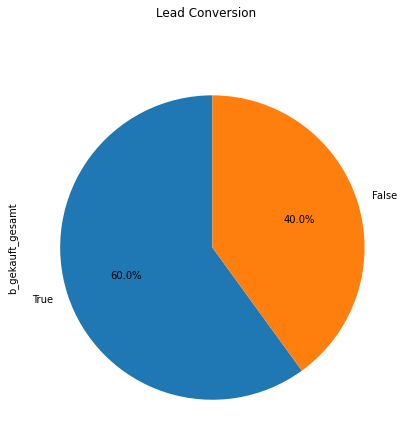

In [9]:
# Total leads that buy a product
total_buys = sum(df['b_gekauft_gesamt'])

# Lead conversion
print('{}% of leads were converted to a buying customer.'.format(round(total_buys/len(df)*100, 2)))

# Plot the proportion of leads and proportion of buying leads in two separate pie charts
fig, ax = plt.subplots(figsize=(7, 7))
df['b_gekauft_gesamt'].value_counts().plot.pie(labels=[True, False], autopct='%.1f%%', ax=ax, startangle=90)
plt.suptitle('Lead Conversion')
plt.show()

#### 3.2. Categorical variables

For categorical variables, we can use the histogram to visualize the distribution, separately for the leads who bought and did not buy the products.

In [10]:
# A function to plot the histogram
def hist_plot(df, feature, hue, ax):
    sns.countplot(data=df, x=feature, hue=hue, ax=ax)
    ax.set_ylabel('Frequency')
    ax.set_xlabel(feature)
    ax.set_title('Histogram Plot: ' + feature)

The `b_specialisation` columns contain binary values, and therefore they are discrete variables. To investigate them, I plotted their distribution using histograms, separated between leads who bought the products and those who did not buy anything. From the histogram, we can quickly observe that customers with specialisation b, c, d, f, and j have higher likelihood to buy a product, and customers that do not specialize in g and h have higher likelihood to buy a product.

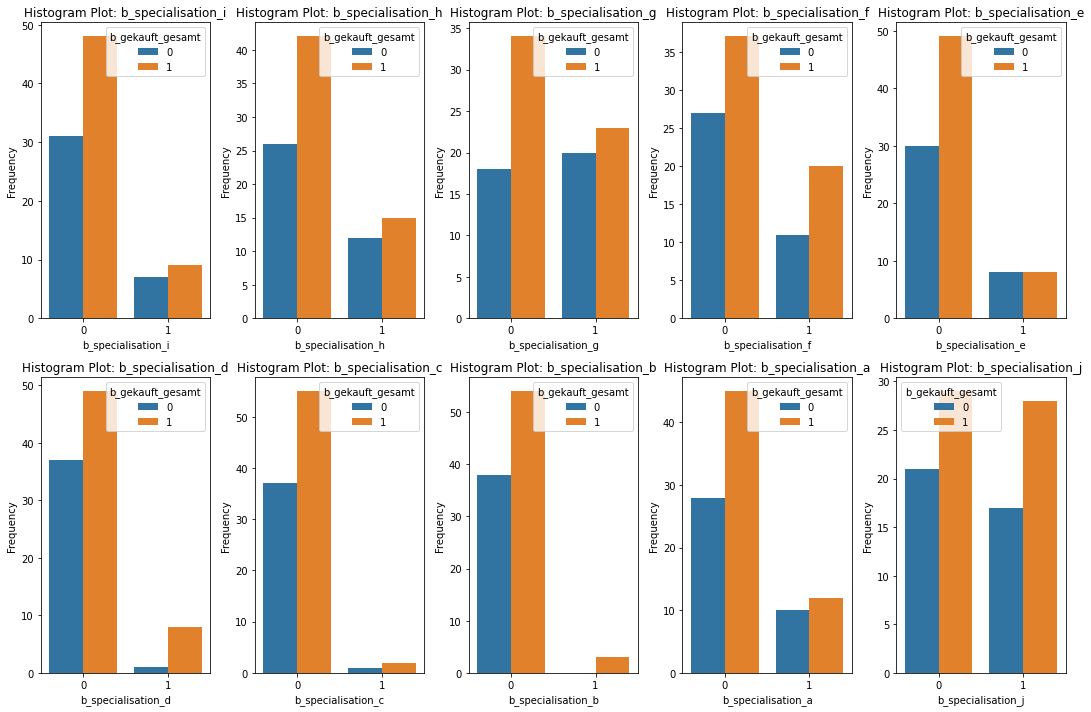

In [11]:
# Extract the columns of b_specialisation
cols_special = [col for col in df.columns if 'b_specialisation' in col]

# Loop over the columns and plot each histogram
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flatten()
for idx, col in enumerate(cols_special):
    hist_plot(df=df, feature=col, hue='b_gekauft_gesamt', ax=ax[idx])
plt.tight_layout()
plt.show()

#### 3.2. Numerical variables
For continuous variables, we can use the kernel density estimation method to visualize the continuous distribution of the data. 

In [12]:
# A function to plot the KDE
def kde_plot(df, feature, hue, ax):
    sns.kdeplot(data=df, x=feature, hue=hue, ax=ax)
    ax.set_ylabel('Density')
    ax.set_xlabel(feature)
    ax.set_title('KDE Plot: ' + feature)

To investigate the continuous variables, I plotted their estimated PDFs using KDE plots, separated between leads who bought the products and those who did not buy anything. From the plots, we can roughly observe that:
- Most of the distributions are bimodal or skewed
- Leads that are in an area with higher average household size are more likely to be converted

The data distribution itself shows some conversion pattern. However, the pattern is still not conclusive and therefore, a fitted model is still required to provide more robustness to the analysis as well as impose objectivity.

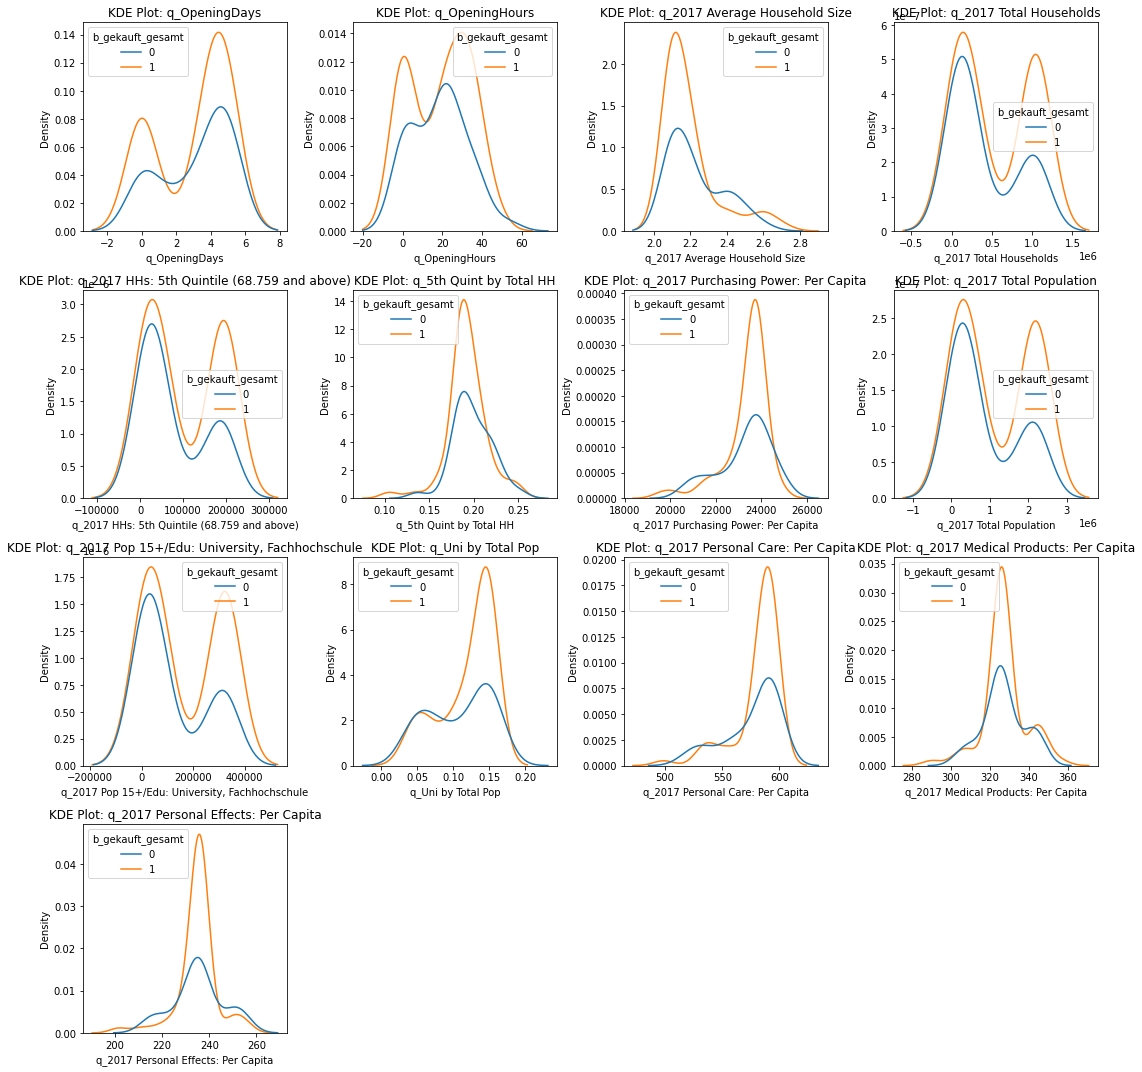

In [13]:
# Extract the columns with the prefix 'q'
cols_q = [col for col in df.columns if 'q_' in col]

# Loop over the columns and plot each histogram
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
fig.delaxes(ax[3,1])
fig.delaxes(ax[3,2])
fig.delaxes(ax[3,3])
ax = ax.flatten()
for idx, col in enumerate(cols_q):
    kde_plot(df=df, feature=col, hue='b_gekauft_gesamt', ax=ax[idx])
plt.tight_layout()
plt.show()

## 4. Model building

In this section, I first inspected the correlation between the feature variables to eliminate redundancy and to simplify the model to prevent overfitting. Next, I divided the data into train and test data, to evaluate the model generalization ability. Finally, because this task is a classification problem, I used the logistic regression model and also searched for an optimal hyperparameter (in this case, the number of features and regularization strengths).

Because there are only 95 data entries available for training and testing, I think that logistic regression is suitable since it is one of the simplest classification model. Additionally, I tested different regularization strength to find the best model and still avoid overfitting.

As a side note: all categorical variables are already encoded, and therefore, no further steps are required for feature encoding.

#### 4.1. Calculation of the correlation between the features
First, the correlation between features was calculated, and the features that had an absolute correlation of 0.6 with another feature were eliminated. For this purpose, I decided to use the Pearson correlation coefficient, because it is the simplest correlation measure and generalizable to various data types. Many variables were found to be highly correlated (especially since some variables are derived from another), and in the end I could eliminate 8 correlated features, resulting in 15 independent features.

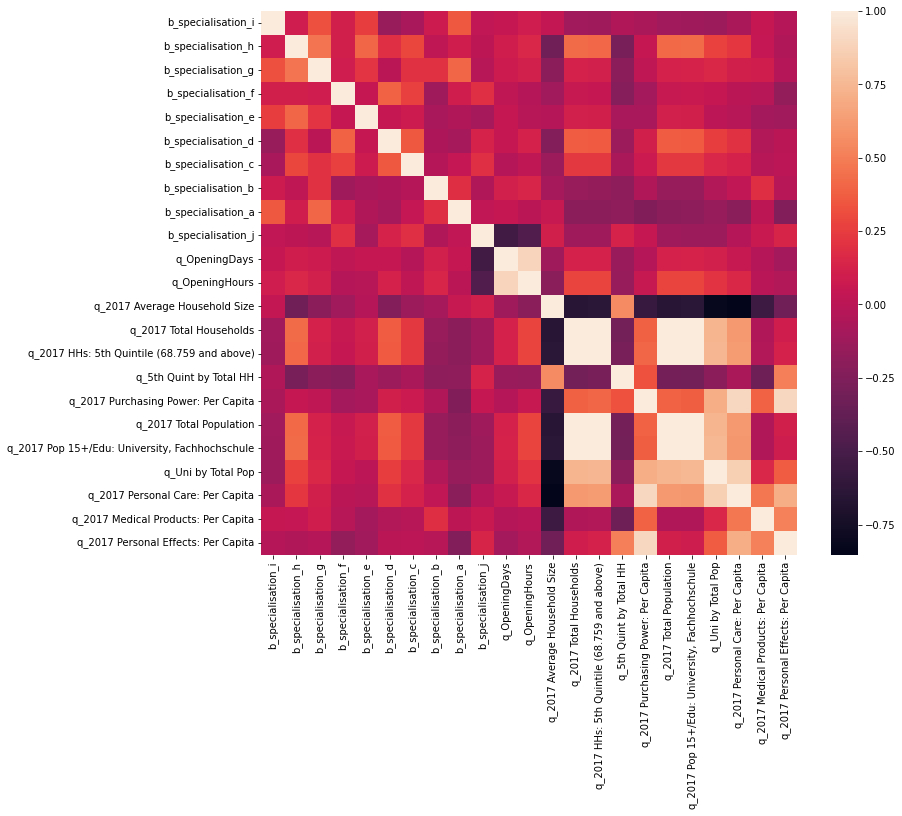

Dropped features:
q_2017 HHs: 5th Quintile (68.759 and above)
q_Uni by Total Pop
q_2017 Total Households
q_2017 Total Population
q_OpeningHours
q_2017 Personal Care: Per Capita
q_2017 Personal Effects: Per Capita
q_2017 Pop 15+/Edu: University, Fachhochschule


In [14]:
# Store the features in a dataframe X
feature_cols = [col for col in df.columns if col not in ['fakeID', 'b_in_kontakt_gewesen', 'b_gekauft_gesamt']]
X = df[feature_cols]

# Store the label in a dataframe y
y = df['b_gekauft_gesamt']

# Calculation of the Pearson correlation
corr_matrix = X.corr()

# Heatmap plotting
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix)
plt.show()

# A function to identify redundant pairs in the correlation matrix,
# taken from https://gist.github.com/shashankvemuri/a210f7399b56075cbe55c309b460fa9b
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

# A function to list the highly-correlated features
def get_features_to_drop(df, cutoff=0.6):
    # Unstacking the correlation matrix
    corr = df.corr().abs().unstack()
    # Identification and removal of redundant pairs
    labels_to_drop = get_redundant_pairs(df)
    corr = corr.drop(labels=labels_to_drop)
    # Identification of the highly-correlated features
    idx = corr[corr > cutoff].index
    feat_to_drop = set()
    for _, i in idx:
        feat_to_drop.add(i)
    return list(feat_to_drop)

# Removal of the columns with high correlations and saving the names of the remaining columns
feat_to_drop = get_features_to_drop(X)
X = X.drop(feat_to_drop, axis=1)
cols = X.columns

# Investigation of the correlated variables
print('Dropped features:')
for feat in feat_to_drop:
    print(feat)

#### 4.2. Logistic regression model training

Before training the model, I split 85% of the data for training and the rest for testing. Because the class is not very imbalanced, I decided to use a normal train-test split method, and not stratified sampling. Then, I built a pipeline for the model training. This pipeline consists of a standard scaler (which standardized all the features), a logistic regression model, a backward recursive feature selector, a K-Fold cross validator (for cross-validation, which is useful with low amount of training data), and a grid search for hyperparameter search (the hyperparameter being the number of features and regularization strength).

From the best model, the importance of the features can be inferred from their coefficient values. Here, the average household size and purchasing power contribute positively to the lead conversion. That means, the higher the number of average household size and purchasing power, the more likely the lead will buy a product. On the other hand, the proportion of the 5th quintile is inversely proportional to the conversion likelihood. This means that if the lead is in an area where there are less proportion of high income households, the more likely they will buy a product. Furthermore, leads that specialize in 'b' and 'd' are also very likely to buy a product, and leads that do not specialize in 'g' and 'h' are more likely to buy a product. The medical products spending per capita seems to have a high influence as well, but according to the distribution plot earlier, this impact is not conclusive.

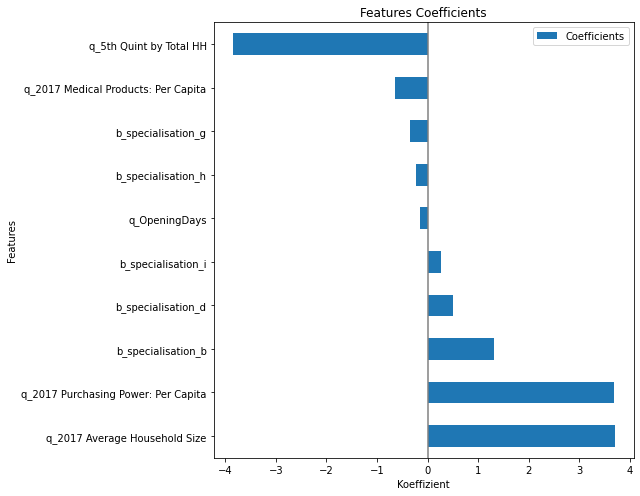

In [15]:
# Split the data into train and test set, random_state = 0 for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

# Scaler to standardize the features
scaler = StandardScaler()

# Backward-Recursive-Feature-Selector, random_state = 0 for reproducibility
selector = RFE(LogisticRegression(random_state=0))

# Pipeline for the optimal hyperparameter search
pipe = Pipeline(steps=[('scaler', scaler), ('selector', selector)])

# Different hyperparameter to be tested, C is the regularization strength (higher means weaker regularization)
param_grid = {'selector__n_features_to_select': list(range(10, len(X.columns)+1, 1)),
              'selector__estimator__C': [0.001, 0.01, 0.1, 1.0, 10, 100]}

# Fit the model for each combination of hyperparameters
search = GridSearchCV(pipe, param_grid, cv=4)
search.fit(X_train, y_train)

# Save the optimal features and the feature coefficients of the best model
feats_opt = X.columns[search.best_estimator_.named_steps['selector'].support_]
coeffs_opt = search.best_estimator_.named_steps['selector'].estimator_.coef_

# Combine the features and the coefficients in a dataframe
coefficients = pd.concat([pd.Series(feats_opt).rename('Features'),
                          pd.Series(np.transpose(coeffs_opt).flatten()).rename('Coefficients')], axis = 1)
coefficients = coefficients.sort_values(by='Coefficients', ascending=False, ignore_index=True)

# Plot the coefficients
fig, ax = plt.subplots(figsize=(9, 7))
coefficients.plot(kind='barh', xlabel='Koeffizient', ylabel='Features', ax=ax)
ax.set_yticklabels(coefficients['Features'])
ax.axvline(x=0, color='.5')
plt.title('Features Coefficients')
plt.tight_layout()
plt.show()

In [16]:
search.best_estimator_.named_steps['selector'].estimator_

LogisticRegression(C=100, random_state=0)

The chosen best model is the model with the weakest regularization. Since we are concerned with overfitting due to the low amount of data, I checked the result of the model trained with the strongest regularization. It turns out that with the strongest regularization, the model learns to assign very low importance to all the features, and a high intercept value. This means that the model almost always predicts positive results, whatever the feature values are, as shown by the confusion matrix below. This is an indication of strong underfitting, and therefore I decided to stick with the best model obtained from the grid search earlier (with C = 100).

In [17]:
# Train a logistic regression model with strong regularization
# and the optimum number of features to check the grid search result
reg_model = LogisticRegression(C= 0.001, random_state=0)
X_train_std = scaler.fit_transform(X_train[feats_opt])
reg_model.fit(X_train_std, y_train)

# Print the model coefficients, intercept, and test confusion matrix to investigate the model
print('Model coefficients: ', reg_model.coef_)
print()
print('Model intercept: ', reg_model.intercept_)
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test, reg_model.predict(scaler.transform(X_test[feats_opt]))))

Model coefficients:  [[ 0.00222699 -0.00139439 -0.00402283  0.00623821  0.00617728 -0.00132366
  -0.00400663 -0.00680254  0.00035288  0.00293654]]

Model intercept:  [0.40548773]

Confusion Matrix:
[[0 6]
 [0 9]]


#### 4.3. Evaluation of the logistic regression model
The best model was evaluated using the test data. The evaluation measures used include: Accuracy, Precision, Recall and F1 score. In addition, a ROC curve is generated and the AUC value is calculated to measure the sensitivity of the model performance to different thresholds. As expected, the model performance is severely limited by the limited data availability, with an accuracy of 60%, precision, recall, and f1 score of 67% each. The AUC for the test data is calculated to be 0.61, which is just slightly better than a baseline model (random guessing). Therefore, the model can be a good start for the company to formulate the marketing strategy. While testing the marketing strategy, the company can also obtain more data to improve the model even further.

Accuracy of the model:  0.6
Precision of the model:  0.67
Recall of the model:  0.67
F1 Score of the model:  0.67


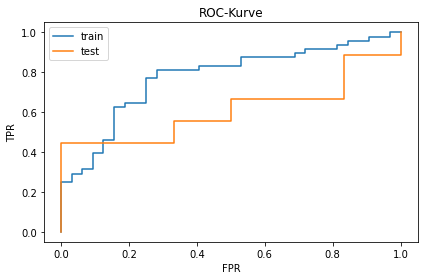

Train AUC:  0.78
Test AUC:  0.61


In [18]:
# Evaluation of the model on unseen test data
print('Accuracy of the model: ', round(accuracy_score(y_test, search.predict(X_test)), 2))
print('Precision of the model: ', round(precision_score(y_test, search.predict(X_test)), 2))
print('Recall of the model: ', round(recall_score(y_test, search.predict(X_test)), 2))
print('F1 Score of the model: ', round(f1_score(y_test, search.predict(X_test)), 2))

# Plot the ROC curve
plt.figure()
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, search.predict_proba(X_train)[:,1])
plt.plot(train_fpr, train_tpr, label='train')
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, search.predict_proba(X_test)[:,1])
plt.plot(test_fpr, test_tpr, label='test')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-Kurve')
plt.legend()
plt.tight_layout()
plt.show()

# Berechnung der AUC
print('Train AUC: ', round(auc(train_fpr, train_tpr), 2))
print('Test AUC: ', round(auc(test_fpr, test_tpr), 2))

#### 4.4. Hypothetical implementation of model on the rest of the data
Finally, the model is applied on the rest of the data, namely to potential leads that have not been contacted, to estimate the number of potential conversion. This is calculated by multiplying the number of positive predictions by the precision score (which is the estimate of the proportion of the correctly predicted positive results).

In [19]:
# Use the rest of the data, where 'b_in_kontakt_gewesen' = 0
df_noleads = pd.read_csv('data/CustomerData_LeadGenerator.csv')
df_noleads = df_noleads[df_noleads['b_in_kontakt_gewesen'] == 0]

# Clean the non-numeric value in the 'q_OpeningHours' column
df_noleads = df_noleads[df_noleads.apply(lambda row: is_float(row['q_OpeningHours']) == True, axis=1)]

# Extract the selected feature columns
X_noleads = df_noleads[cols]

# Predict the number of potential conversion
potential_conversion = int(sum(search.predict(X_noleads)) 
                           * precision_score(y_test, search.predict(X_test)))
print('Potential conversion with accounting for the model precision: ', potential_conversion)

Potential conversion with accounting for the model precision:  1678


## 5. Conclusions and recommendations

Conclusions:
- The model has a test <b>accuracy of 60%, precision of 67%, recall of 67%, and F1-score of 67%</b>. Furthermore, the test <b>AUC is 0.61</b>. All in all, there are still a lot of room for improvement. However, with the low amount of data, the achieved result is still slightly better than random guessing.
- Accounting for a model precision of 67%, the company can try to contact potential customer using the model prediction, which could result in <b>additional 1600 customers</b>.
- The most important variables are: `q_2017 Average Household Size`, `q_2017 Purchasing Power: Per Capita`, `b_specialisation_b`, `b_specialisation_d`, and `q_5th Quint by Total HH`.

Recommendations:
- The classification model is far from perfect, mainly caused by low amount of data. However, the company can use the model to identify potential customers with higher likelihood while gathering more data and continuously improving the model.
- Even though the logistic regression method does not require the input features and residuals to be normally distributed, it still might be worth the effort to transform the features with bimodal distribution and with skewed distribution.
- Other classification models can also be tried, such as decision tree and its ensemble variants. Ensemble models might be very useful for this purpose, as they can deal better with uncertainties (due to the low amount of data).
- The company can focus the marketing target and personalize marketing strategies based on the most important features mentioned in the conclusion above.